In [177]:
num_of_digits = 5
dataset_path = "../../data"

In [41]:
%matplotlib inline


import random

import matplotlib.pyplot as plt
import numpy as np
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [42]:
# Utils
def set_manual_seed(seed: int, random):
  print("Random Seed: ", seed)
  random.seed(seed)
  torch.manual_seed(seed)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# **TRAIN MODEL**

In [178]:
batch_size = 64
train_data = torch.load(f'{dataset_path}/{num_of_digits}_digit_model/mnist_{num_of_digits}_digit_train_data')
test_data = torch.load(f'{dataset_path}/{num_of_digits}_digit_model/mnist_{num_of_digits}_digit_test_data')

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

images type: <class 'torch.Tensor'>
images shape: torch.Size([64, 1, 28, 140])
labels shape: torch.Size([64])


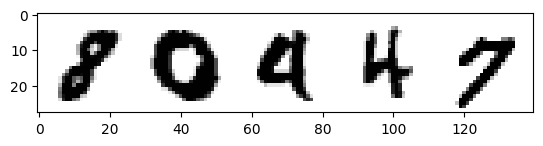

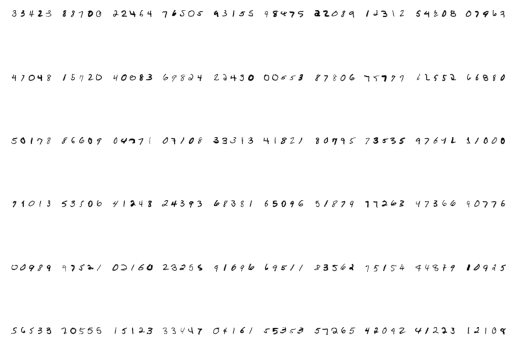

In [179]:
dataiter = iter(train_loader)
images, labels = dataiter._next_data()
print(f'images type: {type(images)}')
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [89]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

In [90]:
# Build network
z_dim = 100
mnist_dim = train_data[0][0].shape[1] * train_data[0][0].shape[2]

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [91]:
# Loss
criterion = nn.BCELoss() 

# Optimizer
lr = 0.00007
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [92]:
# Train the discriminator
def D_train(x):
    D.zero_grad()

    # Train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(batch_size, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # Train discriminator on fake
    z = Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(batch_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # Gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [93]:
# Train the generator
def G_train(x):
    G.zero_grad()

    z = Variable(torch.randn(batch_size, z_dim).to(device))
    y = Variable(torch.ones(batch_size, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # Gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [146]:
# Training
epochs = 1000

for epoch in range(1, epochs + 1):
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), epochs, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/1000]: loss_d: 0.936, loss_g: 1.599
[2/1000]: loss_d: 0.933, loss_g: 1.601
[3/1000]: loss_d: 0.930, loss_g: 1.616
[4/1000]: loss_d: 0.932, loss_g: 1.616
[5/1000]: loss_d: 0.934, loss_g: 1.614
[6/1000]: loss_d: 0.933, loss_g: 1.613
[7/1000]: loss_d: 0.927, loss_g: 1.615
[8/1000]: loss_d: 0.930, loss_g: 1.607
[9/1000]: loss_d: 0.931, loss_g: 1.618
[10/1000]: loss_d: 0.929, loss_g: 1.619
[11/1000]: loss_d: 0.930, loss_g: 1.612
[12/1000]: loss_d: 0.927, loss_g: 1.622
[13/1000]: loss_d: 0.928, loss_g: 1.618
[14/1000]: loss_d: 0.929, loss_g: 1.616
[15/1000]: loss_d: 0.931, loss_g: 1.615
[16/1000]: loss_d: 0.927, loss_g: 1.633
[17/1000]: loss_d: 0.925, loss_g: 1.624
[18/1000]: loss_d: 0.929, loss_g: 1.627
[19/1000]: loss_d: 0.927, loss_g: 1.623
[20/1000]: loss_d: 0.922, loss_g: 1.643
[21/1000]: loss_d: 0.925, loss_g: 1.632
[22/1000]: loss_d: 0.930, loss_g: 1.613
[23/1000]: loss_d: 0.924, loss_g: 1.624
[24/1000]: loss_d: 0.927, loss_g: 1.619
[25/1000]: loss_d: 0.927, loss_g: 1.624
[26/1000]

KeyboardInterrupt: 

In [156]:
torch.save(G, f'{dataset_path}/{num_of_digits}_digit_model/mnist_{num_of_digits}_digit_gan_generator_model')
torch.save(D, f'{dataset_path}/{num_of_digits}_digit_model/mnist_{num_of_digits}_digit_gan_discriminator_model')

In [166]:
# Save image
with torch.no_grad():
    test_z = Variable(torch.randn(batch_size, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28 * num_of_digits), '../../data/sample_' + '.png')

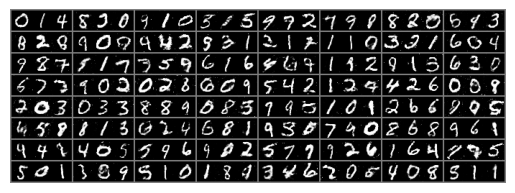

In [173]:
with torch.no_grad():
    test_z = Variable(torch.randn(batch_size, z_dim).to(device))
    generated = G(test_z)

    imshow(torchvision.utils.make_grid(generated.view(generated.size(0), 1, 28, 28 * num_of_digits)))